## plot the mcmc sampling result

In [ ]:
import os, sys
os.environ["MPICH_GPU_SUPPORT_ENABLED"] = "0"
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.cm import get_cmap
from getdist import plots
from desilike.samples import plotting, Chain, Profiles
from desilike.parameter import ParameterCollection

%matplotlib inline

In [ ]:
sys.path.append('../')
from helper import PLANCK_COSMOLOGY, REDSHIFT_BIN_LSS
from plotting_tools import get_mcmc_plot_args, COLOR_TRACERS, get_namespace, plot_observable
from fitting_tools import load_blinded_data_pip, load_bins, get_template, get_theory, get_measurement_fn, get_observable_likelihood
%load_ext autoreload
%autoreload 2

# RESULT_DIR = '/pscratch/sd/s/shengyu/Y3/results/test/full-shape'
RESULT_DIR = '/global/cfs/projectdirs/desi/mocks/cai/mock-challenge-cutsky-dr2/blinded_data/dr2-v2/data_splits/results'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
# plot the 1-d compare
fit       = 'FM'
cosmology = 'LCDM' # LCDM, nuCDM, w0waCDM
theory = 'vel'
task = f'{fit}fit_{cosmology}_{theory}'

(mcmc_args, getdist_args) = get_mcmc_plot_args(task)
(remove_burnin , slice_step) = (mcmc_args[key] for key in ['remove_burnin', 'slice_step'])

tracers = ['BGS','QSO','LRG'] # 'BGS','LRG', 'ELG', 'QSO' 
regions = ["SGC", "NGC", "GCcomb"]
weight_type = 'default_fkp'

TRACER_BINS = [(tracer, zrange) for tracer, zranges in REDSHIFT_BIN_LSS.items()
               if tracer in tracers for zrange in zranges]

all_chains = {}
for tracer, zrange in TRACER_BINS:
    for region in regions:
        if 'BGS' in tracer: tracer = 'BGS_BRIGHT-21.35'
        if 'ELG' in tracer: tracer = 'ELG_LOPnotqso'
        chain_fn = (RESULT_DIR + f'/full-shape/mcmc/chain_{task}_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_{region}_{weight_type}.npy')
        chain = Chain.load(chain_fn)
        all_chains[f'{tracer}_{zrange}_{region}'] = chain

/tmp/ipykernel_1760398/1937396808.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


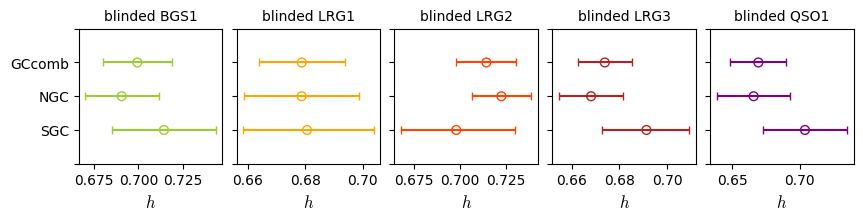

/tmp/ipykernel_1760398/1937396808.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


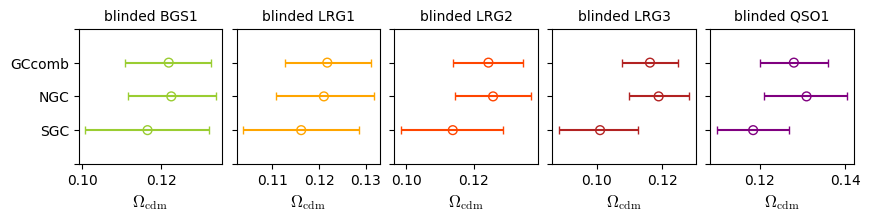

/tmp/ipykernel_1760398/1937396808.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


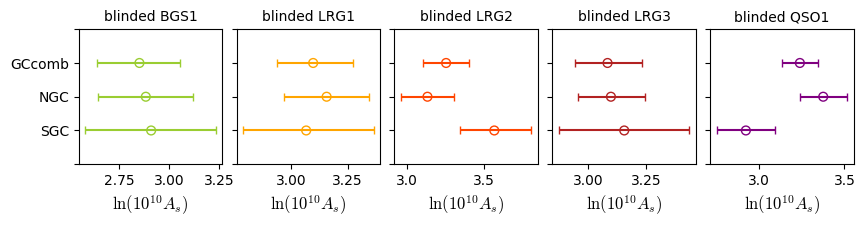

In [53]:
for param, param_label in zip(mcmc_args['params'], mcmc_args['params_label']):
    fig = plt.figure(figsize=(2*len(TRACER_BINS), 0.5*len(regions)))
    gs = gridspec.GridSpec(1, len(TRACER_BINS),  wspace=0.1, hspace=0.0, top=0.95, bottom=0.05)
    n_bins = len(TRACER_BINS)
    yticks = np.arange(len(regions)+2)
    for ind_col, (tracer, zrange) in enumerate(TRACER_BINS):
        if 'BGS' in tracer: tracer = 'BGS_BRIGHT-21.35'
        if 'ELG' in tracer: tracer = 'ELG_LOPnotqso'
        plt.rcParams['mathtext.fontset'] = 'cm' 
        ax = fig.add_subplot(gs[0, ind_col])
        tracer_label = get_namespace(tracer, zrange)
        ax.set_title(f"blinded {tracer_label}", fontsize=10)
        ax.set_yticks(yticks)
        if ind_col == 0:
            ax.set_yticklabels(['']+regions+[''], fontsize=10)
        else:
            ax.set_yticklabels([])
        ax.set_xlabel(param_label, fontsize =12)
        color = COLOR_TRACERS[tracer_label]
        # plot the truth values
        # ax.axvline(mcmc_args['true_values'][param], color='k', linestyle='--', linewidth=1, alpha=0.8,)
        # plot the 1d constraint
        for y, region in enumerate(regions):
            chain0 = all_chains[f'{tracer}_{zrange}_{region}']
            chain = chain0.remove_burnin(remove_burnin)
            mean = chain.mean(params=param)
            q05, q95 = chain.quantile(params=param)  # 5% and 95%
            # horizontal guide line for the region
            ax.scatter(mean, y+1,  edgecolors=color, facecolors='none', s=40)
            ax.errorbar(mean, y+1, xerr=[[mean - q05], [q95 - mean]], color=color, capsize=3)
            ax.set_ylim([0,len(regions)+1])
    plt.tight_layout()
    plt.show()

In [ ]:
# plot the observable vs the best-fit
fit       = 'FM'
cosmology = 'LCDM' # LCDM, nuCDM, w0waCDM
theory = 'vel'
task = f'{fit}fit_{cosmology}_{theory}'

(kmin, kmax, kbin, lenk) = load_bins('pk', 'y3_blinding')

tracer = 'LRG'
region = 'NGC'
zrange = (0.4,0.6)
weight_type = 'default_fkp'

emulator_fn = RESULT_DIR+ f'/emulator/emulator_{task}_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_{region}_{weight_type}_k{kmin}-{kmax}.npy'
data_args = {'tracer':tracer, 'zrange':zrange, 'region':region, 'weight_type':'default_fkp'}
fit_args = {"corr_type": 'pk',  "bins_type": 'y3_blinding', "cov_type":None, 'emulator_fn':emulator_fn}

(likelihood, observable, theory) = get_observable_likelihood(task, data_args, fit_args)
likelihood()

-1135.4828213198457

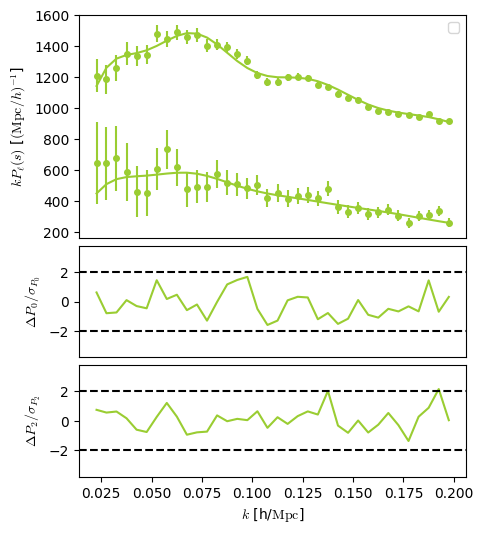

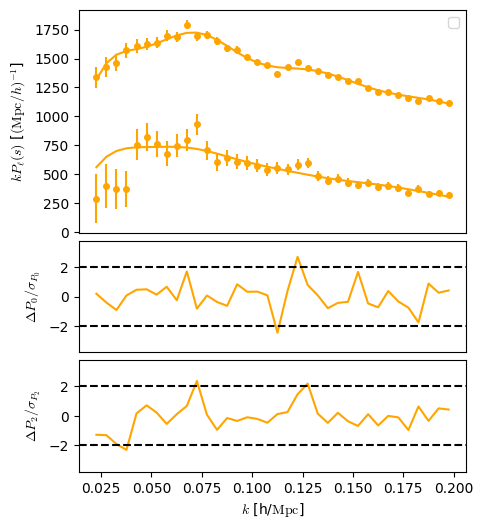

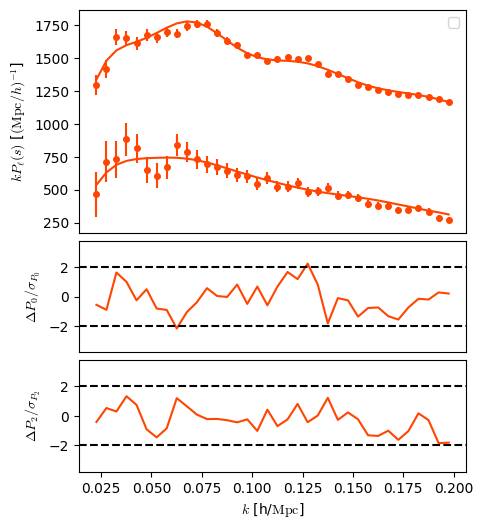

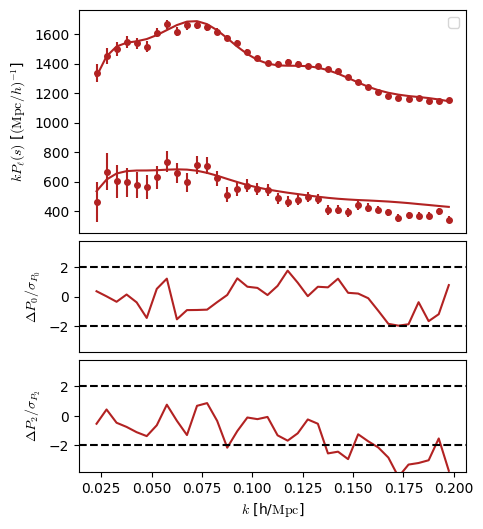

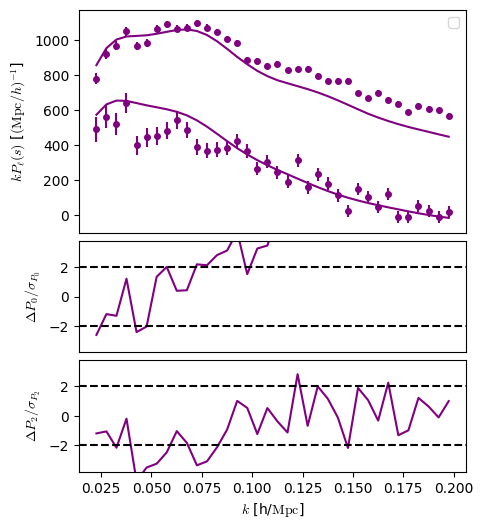

In [ ]:
for ind_col, (tracer, zrange) in enumerate(TRACER_BINS):
    if 'BGS' in tracer: tracer = 'BGS_BRIGHT-21.35'
    if 'ELG' in tracer: tracer = 'ELG_LOPnotqso'
    fig = plt.figure(figsize=(5, 6))
    gs = gridspec.GridSpec(3, 1,  wspace=0.1, hspace=0.05, height_ratios=[2,1,1])
    ax_top = plt.subplot(gs[0])
    ax_bottom = [plt.subplot(gs[1]), plt.subplot(gs[2])]

    tracer_label = get_namespace(tracer, zrange)
    color = COLOR_TRACERS[tracer_label]
    plot_kwargs = {'color':color, 'label':tracer_label}
    # for region in ['GCcomb','NGC','SGC']:
    for region in ['NGC']:
        data_args = {'tracer':tracer, 'zrange':zrange, 'region':region, 'weight_type':'default_fkp'}
        emulator_fn = RESULT_DIR+ f'/emulator/emulator_{task}_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_{region}_{weight_type}_k{kmin}-{kmax}.npy'
        (likelihood, observable, theory) = get_observable_likelihood(task, data_args, fit_args)
        chain0 = all_chains[f'{tracer}_{zrange}_{region}']
        chain = chain0.remove_burnin(remove_burnin)
        likelihood(**chain.choice(index='argmax', return_type='dict', input=True))
        plot_observable(observable, ax_top, ax_bottom, **plot_kwargs)
    plt.show()

In [ ]:


for ind_col, (tracer, zrange) in enumerate(TRACER_BINS):
    

    emulator_fn = RESULT_DIR+ f'/emulator/emulator_{task}_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_{region}_{weight_type}_k{kmin}-{kmax}.npy'
    data_args = {'tracer':tracer, 'zrange':zrange, 'region':region, 'weight_type':'default_fkp'}
    (likelihood, observable, theory) = get_observable_likelihood(task, data_args, fit_args)
        
# data_args = {'tracer':tracer, 'zrange':zrange, 'region':region, 'weight_type':'default_fkp'}

# (likelihood, observable, theory) = get_observable_likelihood(task, data_args, fit_args)


# chain0 = all_chains[f'{tracer}_{zrange}_{region}']
# likelihood(**chain.choice(index='argmax', return_type='dict', input=True))

# fig = plt.figure(figsize=(5, 6))
# gs = gridspec.GridSpec(3, 1,  wspace=0.1, hspace=0.05, height_ratios=[2,1,1])
# ax_top = plt.subplot(gs[0])
# ax_bottom = [plt.subplot(gs[1]), plt.subplot(gs[2])]

# plot_observable(observable, ax_top, ax_bottom)

## Posterior Plot

/tmp/ipykernel_1760398/1426790011.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap('inferno')(np.linspace(0, 1, 6))


Removed no burn in
Removed no burn in
Removed no burn in


NameError: name 'set_true_values' is not defined

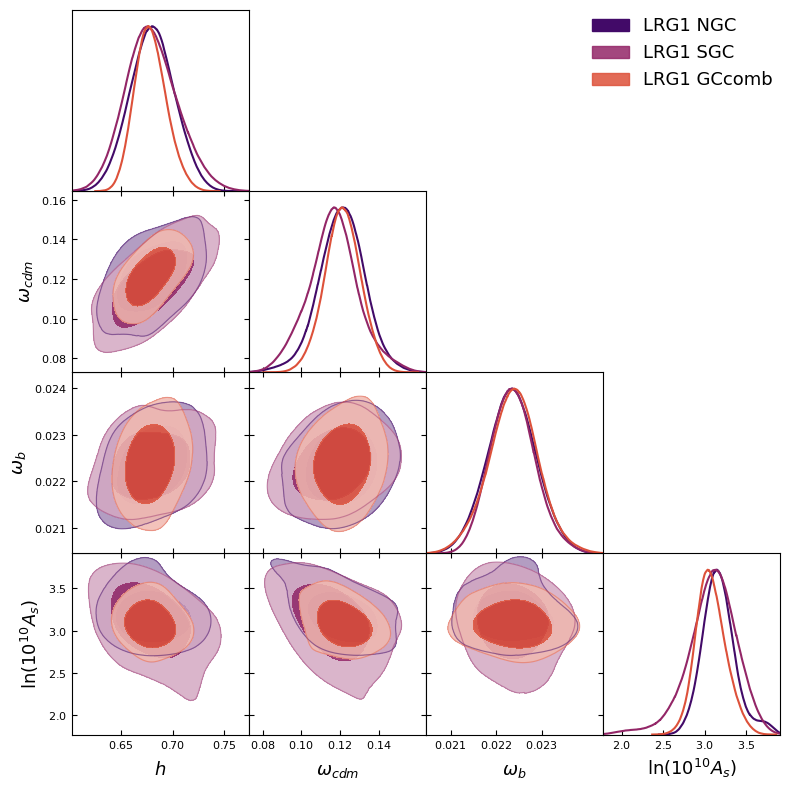

In [51]:
# posterior corener plot
save_fig = False

tracer = 'LRG'
zrange = (0.4,0.6)
weight = 'default_fkp'
regions = ['NGC', 'SGC', 'GCcomb']

fit    = 'FM'
theory = 'vel'
params = ['h', 'omega_cdm','omega_b', 'logA']
labels = [f"{tracer}1 {r}" for r in regions]

chains = []
colors = []
colormap = get_cmap('inferno')(np.linspace(0, 1, 6))

remove_burnin = 0.8
slice_step = 2000

for itask, region in enumerate(regions):
    param_value = []
    chain_fn = RESULT_DIR +f'/full-shape/mcmc/chain_{fit}fit_LCDM_{theory}_{tracer}_z{zrange[0]:.1f}-{zrange[1]:.1f}_{region}_{weight}.npy'
    chain = Chain.load(chain_fn).remove_burnin(remove_burnin)[::slice_step]
    chains.append(chain)
    colors.append(tuple(colormap[itask+1]))
    # print(region, chain.to_stats(params = ['logA','b1p'], tablefmt='pretty'))
g = plots.get_subplot_plotter()
g.settings.fig_width_inch= 8
g.settings.legend_fontsize = 16
g.settings.axes_labelsize = 16
g.settings.figure_legend_frame = False
plotting.plot_triangle(chains, 
                        params = params,
                        legend_labels = labels, legend_loc= 'upper right',
                        contour_lws = 1.5, contour_colors = colors, contour_ls = ['-', '-', '-', '-'],
                        smoothed=True, show=False, filled = [True,True,True,True], g=g
                        )

true_values     = set_true_values(fit, params)
for i in range(len(params)):
    for j in range(i+1):
        g.subplots[i,j].axvline(true_values[j], c = 'k', ls = ':', lw = 1.5)
        if i != j:
            g.subplots[i,j].axhline(true_values[i], c = 'k', ls = ':', lw = 1.5)